# Overview

**GENERAL INFORMATION:**  
This Notebook contains an implementation of a multi-class multi-layer-percepton-classifier (MLP) using PyTorch Lightning on a real world tabular dataset.
For more general details about PyTorch Lightning look at the [README_PyTorchLightning.MD](https://github.com/tiefenthaler/ml_packaging_classification/blob/main/README_PyTorchLightning.MD) (extensive tutorial of using pytorch lightning with tabular data for multi-class classification)  
For more information about the use case look at the [README.MD](https://github.com/tiefenthaler/ml_packaging_classification/blob/main/README.md).

**DATA PREPROCESSING:**  
Imbalanced data:
- over_sampling for imbalanced data.
- cost-sensitive learning for imbalanced data.

continuous data:
- Impute missing data: SimpleImputer(strategy='median').
- Standardize data: StandardScaler().

categorical data:
- Impute missing data: SimpleImputer(strategy='most_frequent').
- Ordinal & Nominal data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).
- Unknown values ecoding and reordering of ordinal encoding: custom encoder "OrdinalEncoderExtensionUnknowns()".

target data:
- target encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

utility functions:
- check_data_consitancy
- check_dataloader_output
- print_dataloader_output
- print_model_summary
- plot_training_metrics

**MULTI-CLASS CLASSIFIER:**  
- Overview models to be considered:  
  - [X] Neural Net: Multi Layer Perceptron (MLP).
    - Learning rate optimization.
    - Callbacks: ValPercentageEarlyStopping.
    - Logging and evaluation of training and validation loss.
    - prediction on test set for evaluation based on classification report.

# Datasets, DataLoaders & LightningDataModule
- Logic of using `Datasets`, `DataLoaders` & `LightningDataModule` for **Tabular Data**  
    Since we are using tabular data and want to perform non tensor based processing to our date, we use Datasets, DataLoaders & LightningDataModule in a different manner as we would do when applying tensor operations (incl. tensor based preprocessing) only.  
    - `LightningDataModule`
        Our LightningDataModule builds the wrapper around this process, with the following intensions:
        - `def prepare_data`  
        Data Operations that only should be performed once on the data (and should not be performed on a distributed manner). Prepares the data for data pre-processing e.g. using sklearn.  
            - Loading the data from .csv to pd.DataFrame
            - General dataset preperations like feature selection and data type correction
        - `def setup`  
        First, data operations (like shuffle, split data, categorical encoding, normalization, etc.), which any dataframe should undergo before feeding into the dataloader will be performed here. Since we use sklearn functionalities for our tabular pre-processing pipeline the data input and output of the pre-processing is a tabular format (dataframe) and not a tensor format.
        Second, the outcome of `def setup` are `Dataset` objects for each split (e.g. train, val, test, pred), which is a wrapper around the pre-processed tabular data and provides the samples and their corresponding labels (ideally in tensor format) in a specific way to be compatible for the model(s).
            - `Dataset`  
            Dataset provides the samples and their corresponding labels in a specific way to be compatible for the model(s). We define the input for our tabular use case as a DataFrame, while the output should generally be a tensor. In our case the output is a tuple of tensors representing contious features, categorical features and a tensor for the target variable (label).
            The class performs specific data type correction for to use of Neural Networks (e.g. ensure that all outputs are numeric values of the correct type depeding of they are categorical or continous nature).
        - `def train/val/test/prediction_dataloader`  
        Creates our dataloaders within the LightningDataModule. See usage below.
            - `DataLoader`
            DataLoader wraps an iterable around the Dataset to enable easy access to the samples during training and inference. The Dataset defines the format of the data that is passed to our model. The DataLoader retrieves our dataset’s features and labels. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval, which is handled by the DataLoader. Input and output is a tensor. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Excorsion: Classical approach of using `Datasets`, `DataLoaders` & `LightningDataModule` for e.g. images, ...  
The main difference is the usage of tensors instead of a dataframe for efficent GPU usage.
    - `LightningDataModule`
        Our LightningDataModule builds the wrapper around this process. It encapsulates training, validation, testing, and prediction dataloaders, as well as any necessary steps for data processing, downloads, and transformations. https://lightning.ai/docs/pytorch/stable/data/datamodule.html
        - `def prepare_data`  
        Loads the data and does general processing befor transfomring to a tensor, so efficent tensor operations can be enabled in `setup'.
        - `def setup`  
        Efficent tensor operations (like shuffle, split data, categorical encoding, normalization, etc.), which any dataframe should undergo before feeding into the dataloader.
        - `def train/val/test_dataloader`  
        Creates our dataloaders within the LightningDataModule.
    - `Dataset`
    Class to create tabular dataset to follow PyTorch Lightning conventions (eventhough we are working on tabular data), where the data for feature variables and the target variable are often already provided in a combined way (e.g. contrary to images and corresbonding labels). For "classical" approaches a Dataset class is often used at the start of the machine learning pipeline to provide the data in a format (e.g. combine images and corresponding labels, which are typically not provided in the same file) for further processing and training.

In [1]:
colab = False

In [2]:
if colab:
    # Import the library to mount Google Drive
    from google.colab import drive
    # Mount the Google Drive at /content/drive
    drive.mount('/content/drive')
    # Verify by listing the files in the drive
    # !ls /content/drive/My\ Drive/
    # current dir in colab
    !pwd

In [3]:
if colab:
    !pip install optuna==3.5.0
    # !pip install optuna.integration
    !pip install lightning

In [4]:
# import os
import sys
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

In [5]:
from typing import Dict, Iterable, List, Optional, Tuple, Union, Literal

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   OrdinalEncoder, StandardScaler)
from sklearn.metrics import classification_report

# import imblearn
from imblearn.over_sampling import RandomOverSampler

In [7]:
import lightning as L
from lightning.pytorch.tuner import Tuner
import torch
from torch import nn
from torchmetrics import Metric
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score
from torch.utils.data import DataLoader, Dataset
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# NOTE: if used in google colab, upload env_vars_colab.yml to current google colab directory!

In [9]:
# get config
if colab:
    with open('./env_vars_colab.yml', 'r') as file:
        config = yaml.safe_load(file)
else:
    with open('../env_vars.yml', 'r') as file:
        config = yaml.safe_load(file)
sys.path.append(config['project_directory'])

In [ ]:
# custom imports
from src.tabular_lightning import encoders
# from src.tabular_lightning import tabular_lightning_utils as tl_utils

In [11]:
SEED = 42 # Ensure same data split as in other notebooks

# Load Data using Dataset Class

In [12]:
class TabularDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame = None,
        continuous_cols: Optional[List[str]] = None,
        categorical_cols: Optional[List[str]] = None,
        target: Optional[List[Union[str, int, float]]] = None,
        task: Literal["classification", "regression"] = "classification",
    ) -> None:
        """
        This class is customized for tabular related data for the use of classification and regression. Returns the tabular data as tensor format.
        Input data must be of numeric nature and should be ordinal or label encoded. This should be covered by a related LightningDataModule.
        Besides the standard functionality of the 'Dataset' class it provides data type correction to fit the requirements of Neural Networks and for efficent use of Neural Networks.
        NOTE: The common/original intention of using a Torch Dataset Class, is to provide the output of the data as tensors for further use of pytorch
              and to enable tensor operations. For our (and most) tabular datasets we neglect the aspect of tensor operations, since we do the data transformations (e.g. using sklearn),
              which are not tensor based, within a L.LightningDataModule. The TabularDataset class is used to provide the data as tensors to the DataLoaders as a final step after data prepressing.

        Args:
            data (pd.DataFrame): Pandas DataFrame to load during training, validation, testing and prediction.
            continuous_cols (List[str], optional): A list of names of continuous columns.
            categorical_cols (List[str], optional): A list of names of categorical columns. These columns must be ordinal or label encoded beforehand.
            target (List[str], optional): A list of strings with target column name(s).
            task (str): Whether it is a classification or regression task. If classification, it returns a LongTensor as target.
        Returns:
            Corrected tabular data as tensor format.
        """
        # self.data = data
        self.task = task
        self.n_samples = data.shape[0]
        self.categorical_cols = categorical_cols
        self.continuous_cols = continuous_cols
        self.target = target

        # NOTE: input data must be ordinal or label encoded

        # target handling
        if self.target:
            self.y = data[self.target].astype(np.float32).values  # for regression task
            if self.task == "classification":
                # self.y = self.y.reshape(-1, 1).astype(np.int64) # for classification task, reshape for multi class classification (must be handled accordingly in the model)
                self.y = self.y.astype(np.int64)  # for classification task
        else:
            self.y = np.zeros((self.n_samples, 1))  # for regression task
            if self.task == "classification":
                self.y = self.y.astype(np.int64)  # for classification task

        # feature handling
        self.categorical_cols = self.categorical_cols if self.categorical_cols else []
        self.continuous_cols = self.continuous_cols if self.continuous_cols else []
        if self.continuous_cols:
            self.continuous_X = data[self.continuous_cols].astype(np.float32).values
        if self.categorical_cols:
            self.categorical_X = data[self.categorical_cols].astype(np.int64).values
            # self.categorical_X = self.categorical_X.astype(np.int64) # TODO: remove

    @property
    def get_dataframe(self) -> pd.DataFrame:
        """Creates and returns the dataset as a pandas dataframe."""
        if self.continuous_cols or self.categorical_cols:
            df = pd.DataFrame(
                dict(zip(self.continuous_cols, self.continuous_X.T))
                | dict(zip(self.categorical_cols, self.categorical_X.T))
            )
        else:
            df = pd.DataFrame()
        df[self.target] = self.y  # add target column

        return df

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return self.n_samples

    def __getitem__(self, idx: int = None) -> Dict[str, torch.Tensor]:
        """
        Generates one single sample of data of the dataset (row)
        and applies transformations to that sample if defined.
        Called iteratively based on batches and batch_size.
        Args:
            idx (int): index (between ``0`` and ``len(dataset) - 1``)

        Returns:
            Tuple[Dict[str, torch.Tensor], torch.Tensor]: x and y for model
        """

        return {
            "continuous": (torch.as_tensor(self.continuous_X[idx]) if self.continuous_cols else torch.Tensor()),
            "categorical": (torch.as_tensor(self.categorical_X[idx]) if self.categorical_cols else torch.Tensor()), #  dtype=torch.int64
            "target": torch.as_tensor(self.y[idx]) # , dtype=torch.long
        }

# Pre-process Data using DataLoader Class

In [13]:
class TabularDataModuleClassificationPACKAGING(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str,
        continuous_cols: List[str] = None,
        categorical_cols: List[str] = None,
        target: List[str] = None,
        oversampling: bool = False,
        task_dataset: str = "classification",
        test_size: Optional[float] = None,
        val_size: Optional[float] = None,
        batch_size: int = 64,
        batch_size_inference: Optional[int] = None,
        num_workers_train: int = 0,
        num_workers_predict: int = 0,
        kwargs_dataloader_trainvaltest: Dict = {},
        kwargs_dataloader_predict: Dict = {},
        SEED: Optional[int] = 42,
    ) -> None:
        """
        The class processes the data accordingly, so that the output meets the requirments to be further use of PyTorch/Lightning.
        A shareble, reusable class that encapsulates data loading and data preprocessing logic for classification.
        The class provides general data handeling and very specific data handeling to the 'Packaging Dataset' ('number` and 'object' types as variables are supported, but no other e.g. like 'date').
        NOTE: In addition, the common/original intention of using a L.LightningDataModule is to performe data operations on tensors to improve compute performance. For our (and most) tabular datasets we neglect this aspect,
            since we perform data transformations, which are not tensor based. Therefore data preprocessing and transformations are organized within the class methods 'prepare_data' and 'setup',
            based on if they should be performed a single time only or multiple times (e.g. on each split seperately).
        NOTE: Be aware of the status of your pre-processing pipeline / transformers (data they are fit on) - performance optimization vs. final evaluation vs. inference only.
            The stage parameter ('fit' or 'inference') in def _preprocessing_pipeline controls this internal logic.
        NOTE: Training, validation, testing and prediction are triggered by the Lightning Trainer() methods (.fit(), .validate(), .test() and .predict()).
            The stage parameter ('fit', 'validate', 'test' and 'predict') controles the internal logic to provide the correct data splitting and dataloader generation.

        Args:
            data_dir (str): The directory where the data is stored.
            continuous_cols (List[str], optional): A list of column names for continuous variables. Defaults to None.
            categorical_cols (List[str], optional): A list of column names for categorical variables. Defaults to None.
            target (List[str], optional): A list of column names for the target variable. Defaults to None.
            oversampling (bool, optional): Whether to perform oversampling. Defaults to False.
            task_dataset (str, optional): The type of task dataset. Defaults to 'classification'.
            test_size (Optional[float], optional): The size of the test set. Defaults to None.
            val_size (Optional[float], optional): The size of the validation set. Defaults to None.
            batch_size (int, optional): The batch size for training. Defaults to 64.
            batch_size_inference (Optional[int], optional): The batch size for inference. Defaults to None.
            num_workers_train (int, optional): The number of workers for training. Defaults to 0, which is the main thread (always recoommended).
            num_workers_predict (int, optional): The number of workers for inference. Defaults to 0, which is the main thread (always recoommended).
            kwargs_dataloader_trainvaltest (Dict, optional): Additional keyword arguments for the dataloader for training, validation, and testing. Defaults to {}.
            kwargs_dataloader_predict (Dict, optional): Additional keyword arguments for the dataloader for prediction. Defaults to {}.
            SEED (Optional[int], optional): The seed for reproducibility. Defaults to 42.
        """
        super().__init__()
        # self.save_hyperparameters()
        self.data_dir = data_dir
        self.categorical_cols = categorical_cols if categorical_cols else []
        self.continuous_cols = continuous_cols if continuous_cols else []
        self.task_dataset = task_dataset
        self.task = task_dataset
        self.test_size = test_size
        self.val_size = val_size
        self.target = target
        self.oversampling = oversampling
        self.batch_size = batch_size
        self.batch_size_inference = self.batch_size if not batch_size_inference else batch_size_inference
        self.num_workers_train = num_workers_train
        self.num_workers_predict = num_workers_predict
        self.kwargs_dataloader_trainvaltest = kwargs_dataloader_trainvaltest
        self.kwargs_dataloader_predict = kwargs_dataloader_predict
        self.stage_setup = None
        self.SEED = SEED

        self._prepare_data_called = False

    def _prepare_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Performs general, use case independent data input handeling and data type handling.
        Used internal in 'prepare_data' for train, val and test dataloaders and in 'inference_dataloader' for prediction.
        Target specific handelings are performed in 'perpare_data' to avoid conflicts during inference only scenarios where the target is not available.
        General data preparation involves:
            - transform target variable to data type 'object' for classificatiomn tasks and to data type 'float32' for regression tasks.
            - transform continuous feature variables to data type 'np.float32'.
            - transform categorical feature variables to data type 'object'.
            - update the processed dataframe accordingly and drops not specified columns.
        """
        if self.task == "classification":
            # transform target variable to data type 'object'
            data[self.target] = data[self.target].astype("object").values
        elif self.task == "regression":
            # transform target variable to data type 'float32'
            data[self.target] = data[self.target].astype(np.float32).values

        if len(self.continuous_cols) > 0:
            # continuous_cols will be transfomred to float32 ('32' for performance reasons) since NNs do not handle int properly.
            data[self.continuous_cols] = data[self.continuous_cols].astype(np.float32).values
        if len(self.categorical_cols) > 0:
            # ensure that all categorical variables are of type 'object'
            data[self.categorical_cols] = data[self.categorical_cols].astype('object').values

        if (len(self.continuous_cols) > 0) or (len(self.categorical_cols) > 0):
            self.feature_cols = self.continuous_cols + self.categorical_cols
            pass
        else:
            raise TypeError("Missing required argument: 'continuous_cols' and/or 'categorical_cols'")

        # Define a subset based on continuous_cols and categorical_cols
        data = data[self.continuous_cols + self.categorical_cols + self.target]

        return data

    def _preprocessing_pipeline(
        self, X: pd.DataFrame = None, y: pd.DataFrame = None, stage: str = "fit"
    ) -> pd.DataFrame:
        """
        PREPROCESSING PIPELINE, used internal in 'setup' for train, val and test dataloaders and in 'inference_dataloader',
        as well as for inverse transformations.
        TabularDatasetPACKAGING prepares data for prediction only accordingly to support _preprocessing_pipeline.
        """
        # create pipeline for fit scenario, use existing pipeline for inference scenario
        if stage == "fit":
            # numerical feature processing
            numerical_features = X.select_dtypes(include='number').columns.tolist()
            numeric_feature_pipeline = Pipeline(steps=[
                ('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())
            ])
            # categorical feature processing
            categorical_features = X.select_dtypes(exclude='number').columns.tolist()
            categorical_feature_pipeline = Pipeline(steps=[
                ('impute', SimpleImputer(strategy='most_frequent')),
                ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), # ordinal is used instead of label encoder to avoid conflicts with inference or
                ('nan_label', encoders.OrdinalEncoderExtensionUnknowns()),
            ])
            # apply both pipeline on seperate columns using "ColumnTransformer"
            self.preprocess_pipeline = ColumnTransformer(transformers=[
                ('number', numeric_feature_pipeline, numerical_features),
                ('category', categorical_feature_pipeline, categorical_features)],
                verbose_feature_names_out=False)
            self.preprocess_pipeline.set_output(transform="pandas")

            # ordinal is used instead of label encoder to avoid conflicts with inference or
            # conflicts caused by data splits of categories with low numerber of classesonly scenarios
            self.label_encoder_target = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            # self.label_encoder_target = LabelEncoder()

        if stage == "fit":
            X_transformed = self.preprocess_pipeline.fit_transform(X)
            y_transformed = pd.DataFrame(data=self.label_encoder_target.fit_transform(y.values.reshape(-1, 1)), index=y.index, columns=y.columns)
        elif stage == 'inference':
            X_transformed = self.preprocess_pipeline.transform(X)
            y_transformed = pd.DataFrame(data=self.label_encoder_target.transform(y.values.reshape(-1, 1)), index=y.index, columns=y.columns)
        else:
            raise ValueError(f"Missing required argument 'stage', must be 'fit' or 'inference', got {stage}")

        return pd.concat([X_transformed, y_transformed], axis=1)

    def prepare_data(self, shuffle: bool = False) -> None:
        """Custom data specific operations and basic tabular specific operations that only should be performed once on the data (and should not be performed on a distributed manner).
        Load the data as Tabular Data as a Pandas DataFrame from a .csv file and performs custom data processing related to loading a .csv file (data type correction) and defining a subset of features.
        In addition "_prepare_data" performace general data preparation for the classification/regression task and perform basic data error handeling. General data preparation involves:
            - transform target variable to data type 'object'.
            - update the processed dataframe accordingly and drops not specified columns.
            - shuffle the data (rows).
        """

        # USE CASE SPECIFIC DATA HANDLING
        self.data = pd.read_csv(self.data_dir, sep="\t")
        # for inference mode, as the target might not be provided in the data, ensures pre-processing pipeline completes correctly.
        if 'packaging_category' not in self.data.columns:
            self.data.insert(len(self.data.columns), 'packaging_category', np.nan) # Insert an empty column at the end (position=-1)
        # define the subset
        self.data = self.data[[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'material_weight',
            'packaging_code',
            'packaging_category',
        ]]
        self.data['material_number'] = self.data['material_number'].astype('object')

        if self.oversampling:
            # NOTE: Oversampling so each class has at least 100 sample; to properly represent minority classes during training and evaluation
            X = self.data.iloc[:, :-1]
            y = self.data.iloc[:, -1]  # the last column is the target, ensured based on section before (# select a subset)
            dict_oversmapling = {
                "Metal Cassette": 100,
                "Carton tube with or w/o": 100,
                "Wooden box": 100,
                "Fabric packaging": 100,
                "Book packaging": 100,
            }
            oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=self.SEED)
            X_oversample, y_oversample = oversampler.fit_resample(X, y)
            self.data = pd.concat([X_oversample, y_oversample], axis=1)

        # GENERAL DATA HANDLING
        self.data = self._prepare_data(self.data)

        # shuffle data
        if shuffle is True: self.data = self.data.sample(frac=1)

        self.n_samples = self.data.shape[0]

        self._prepare_data_called = True

    def setup(self, stage: str = None) -> None:
        """Data Operations (like shuffle, split data, categorical encoding, normalization, etc.) that will be performed multiple times, which any dataframe should undergo before feeding into the dataloader.
        Since on tabular data, operations like transformations (categorical encoding, normalization, etc.) needs to be performed with respect to all samples (respectively separat per train, val, test split),
        most operations are not performed in DDP way. See class docstring for further details regarding tabular data and tensor transformations.

        Args:
            test_size (Optional[float], optional):
                Defines the hold out split that should be used for final performance evaluation. If 'None' no split will be performed and all data is used in 'fit'
            val_size (Optional[float], optional):
                Defines an additional split on the train data that should be used for model optimization. If 'None' no val split will be performed and all train data is used in 'fit'
            stage (Optional[str], optional):
                Internal parameter to distinguish between 'fit', 'validate', 'test' and 'predict'. Defaults to None.
        """

        self.stage_setup = stage

        if not self._prepare_data_called:
            raise RuntimeError("'prepare_data' needs to be called before 'setup'")

        # Define features and target
        X = self.data.iloc[:, :-1]
        y = self.data.iloc[:, -1]  # the last column is the target, ensured by calling 'prepare_data' upfront

        # Define data for train, val and test and for prediction
        if stage in ("fit", "validate", "test"):
            # Generate train, val and test data splits
            if self.test_size is not None:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=self.test_size, stratify=y, random_state=self.SEED
                )
                X_train = pd.DataFrame(data=X_train, columns=X.columns)
                y_train = pd.DataFrame(data=y_train, columns=[y.name])
                X_test = pd.DataFrame(data=X_test, columns=X.columns)
                y_test = pd.DataFrame(data=y_test, columns=[y.name])
                if (self.val_size is not None) and (self.test_size is not None):
                    X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=self.val_size, stratify=y_train, random_state=self.SEED
                    )
                    X_train = pd.DataFrame(data=X_train, columns=X.columns)
                    y_train = pd.DataFrame(data=y_train, columns=[y.name])
                    X_val = pd.DataFrame(data=X_val, columns=X.columns)
                    y_val = pd.DataFrame(data=y_val, columns=[y.name])
            else:
                X_train = X
                y_train = pd.DataFrame(data=y, columns=[y.name])
        elif stage == "predict":
            X_pred = X
            y_pred = pd.DataFrame(data=y, columns=[y.name])
        else:
            raise ValueError(f"Stage must be 'fit', 'validate', 'test' or 'predict', got {stage}")

        # pre-process data
        if stage in ("fit", "validate", "test"):
            # the logic ensures that y_train is during all training scenarios and inference scenario always the right reference for number of classes.
            tabular_train = self._preprocessing_pipeline(X_train, y_train, stage="fit")
            if self.test_size is not None:
                tabular_test = self._preprocessing_pipeline(X_test, y_test, stage='inference')
            if (self.val_size is not None) and (self.test_size is not None):
                tabular_val = self._preprocessing_pipeline(X_val, y_val, stage='inference')
            # n_classes is calculated based on set of unique classes in train, val, test after preprocessing to handle unknown classes properly.
            self.n_classes = len(
                set(tabular_train[y.name].unique())
                .union(*(set(df[y.name].unique()) for df in (tabular_val, tabular_test) if df is not None))
            )
        elif stage == 'predict':
            tabular_predict = self._preprocessing_pipeline(X_pred, y_pred, stage='inference')

        # create datasets
        # NOTE: instanziation of datasets (train, val test) in stage == ('fit', 'validate', 'test') is controlled by self.test_size and self.val_size
        #       instanziation of datasets (predict) is controlled by stage == 'predict'
        if stage in ("fit", "validate", "test"):
            self.train_dataset = TabularDataset(
                data=tabular_train,
                continuous_cols=self.continuous_cols,
                categorical_cols=self.categorical_cols,
                target=self.target,
                task=self.task_dataset,
            )
            if self.test_size is not None:
                self.test_dataset = TabularDataset(
                    data=tabular_test,
                    continuous_cols=self.continuous_cols,
                    categorical_cols=self.categorical_cols,
                    target=self.target,
                    task=self.task_dataset,
                )
            if (self.val_size is not None) and (self.test_size is not None):
                self.val_dataset = TabularDataset(
                    data=tabular_val,
                    continuous_cols=self.continuous_cols,
                    categorical_cols=self.categorical_cols,
                    target=self.target,
                    task=self.task_dataset,
                )
        elif stage == "predict":
            self.predict_dataset = TabularDataset(
                data=tabular_predict,
                continuous_cols=self.continuous_cols,
                categorical_cols=self.categorical_cols,
                target=self.target,
                task=self.task_dataset,
            )
        else:
            raise ValueError(f"Stage must be 'fit', 'validate', 'test' or 'predict', got {stage}")

    def train_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer fit() method uses.
        Args:
            batch_size (Optional[int], optional): Batch size. Defaults to `self.batch_size`.
        Returns:
            DataLoader: Train dataloader
        """
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=self.num_workers_train,
            **self.kwargs_dataloader_trainvaltest,
        )

    def val_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer fit() and validate() methods uses.
        Args:
            batch_size (Optional[int], optional): Batch size. Defaults to `self.batch_size`.
        Returns:
            DataLoader: Validation dataloader
        """
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers_train,
            **self.kwargs_dataloader_trainvaltest,
        )

    def test_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer test() method uses.
        Args:
            batch_size (Optional[int], optional): Batch size. Defaults to `self.batch_size`.
        Returns:
            DataLoader: Test dataloader
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers_train,
            **self.kwargs_dataloader_trainvaltest,
        )

    def predict_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer predict() method uses.
        Used for predictions for data with unknow target (labes).
        Args:
            batch_size (Optional[int], optional): Batch size. Defaults to `self.batch_size`.
        Returns:
            DataLoader: Test dataloader
        """
        if self.stage_setup == 'predict':
            return DataLoader(
                self.predict_dataset,
                batch_size=self.batch_size_inference,
                shuffle=False,
                num_workers=self.num_workers_predict,
                **self.kwargs_dataloader_predict,
            )
        else:
            return None

In [14]:
dm = TabularDataModuleClassificationPACKAGING(
    data_dir=f"{config['data_directory']}/output/df_ml.csv",
    continuous_cols=['material_weight'],
    categorical_cols=[
        'material_number',
        'brand',
        'product_area',
        'core_segment',
        'component',
        'manufactoring_location',
        'characteristic_value',
        'packaging_code'
    ],
    target=['packaging_category'],
    oversampling=True,
    test_size=0.2,
    val_size=0.2,
    batch_size=64,
    SEED=SEED
)

In [15]:
# NOTE: Run dm.prepare_data() and dm.setup() to get information from the dataset to build the model.
dm.prepare_data()
dm.setup(stage='fit')
# dm.data.info()
# dm.data.head()

In [16]:
dm.train_dataset.get_dataframe.head(5)

,material_weight,material_number,brand,product_area,core_segment,component,manufactoring_location,characteristic_value,packaging_code,packaging_category
0,-0.014936,2435,6,2,13,8421,17,282,35,1
1,-0.015001,10594,6,2,20,8355,17,282,33,22
2,-0.014273,6018,3,2,17,91,13,353,57,26
3,-0.015043,18002,2,3,3,12257,11,291,86,0
4,-0.015105,5511,2,1,8,4312,11,291,58,13


In [17]:
def check_data_consitancy(dm: TabularDataModuleClassificationPACKAGING = None) -> None:
    """Tests the consistency of the data.
    Args:
        dm: pre-processed datamodule from class TabularDataModuleClassificationPACKAGING
    """
    tabular_data_full = pd.concat([
        dm.train_dataset.get_dataframe,
        dm.val_dataset.get_dataframe,
        dm.test_dataset.get_dataframe
    ], axis=0, ignore_index=True)
    # check column names
    assert dm.data.columns.tolist() == tabular_data_full.columns.tolist()
    # check shape of input data and processed data
    assert dm.data.shape == tabular_data_full.shape

check_data_consitancy(dm)

In [18]:
def check_dataloader_output(
    dm: TabularDataModuleClassificationPACKAGING = None,
    out: Dict[str, torch.Tensor] = None,
) -> None:
    """Tests the output of the dataloader.
    Args:
        dm: pre-processed datamodule from class TabularDataModuleClassificationPACKAGING
        out: output of the dataloader
    """

    continuous_x = out["continuous"]
    categorical_x = out["categorical"]
    y = out["target"]

    assert isinstance(y, torch.Tensor), "y output should be a torch.Tensor"

    # check continuous features for nans and finite
    assert torch.isfinite(continuous_x).all(), f"Values for {categorical_x} should be finite"
    assert not torch.isnan(continuous_x).any(), f"Values for {categorical_x} should not be nan"
    assert continuous_x.dtype == torch.float32, f"Values for {categorical_x} should be of type float32"
    # check categorical features for nans and finite
    assert torch.isfinite(categorical_x).all(), f"Values for {categorical_x} should be finite"
    assert not torch.isnan(categorical_x).any(), f"Values for {categorical_x} should not be nan"
    assert categorical_x.dtype == torch.int64, f"Values for {categorical_x} should be of type int64"

    # check target for nans and finite
    assert torch.isfinite(y).all(), "Values for target should be finite"
    assert not torch.isnan(y).any(), "Values for target should not be nan"
    assert y.dtype == torch.int64, "Values for target should be of type int64"

    # check shape
    assert continuous_x.size(1) == dm.data[dm.continuous_cols].shape[1]
    assert categorical_x.size(1) == dm.data[dm.categorical_cols].shape[1]

check_dataloader_output(dm, next(iter(dm.train_dataloader())))

In [19]:
def print_dataloader_output(dm: TabularDataModuleClassificationPACKAGING = None) -> None:
    """Prints the output of the dataloader.
    Args:
        dm: pre-processed datamodule from class TabularDataModuleClassificationPACKAGING
    """
    num_epochs = 1
    for epoch in range(num_epochs):

        for batch_idx, dict in enumerate(dm.train_dataloader()):
            print("Batch:", batch_idx)
            if batch_idx >= 1:
                break
            for k, v in dict.items():
                print(k, v.shape)

            network_input = torch.cat((dict["continuous"], dict["categorical"]), dim=1)
            print(
                "Shape of network input:", network_input.shape,
                "Data Types Cont:", [column.dtype for column in dict["continuous"].unbind(1)],
                "Data Types Cat:", [column.dtype for column in dict["categorical"].unbind(1)],
            )
            # print("Shape of target flatten:", dict['target'].flatten().shape, "Data Types:", dict['target'].flatten().dtype)
            print("Shape of target flatten:", dict['target'].shape, "Data Types:", dict['target'].dtype)
            print("Target from current batch:", dict['target'][:5])
            print("Dataloader output from current batch, Cont:", dict["continuous"][:3])
            print("Dataloader output from current batch, Cat:", dict["categorical"][:3])

print_dataloader_output(dm)

Batch: 0
continuous torch.Size([64, 1])
categorical torch.Size([64, 8])
target torch.Size([64, 1])
Shape of network input: torch.Size([64, 9]) Data Types Cont: [torch.float32] Data Types Cat: [torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64]
Shape of target flatten: torch.Size([64, 1]) Data Types: torch.int64
Target from current batch: tensor([[12],
        [22],
        [ 0],
        [26],
        [ 0]])
Dataloader output from current batch, Cont: tensor([[-0.0116],
        [-0.0151],
        [-0.0150]])
Dataloader output from current batch, Cat: tensor([[ 8515,     7,     4,     4,  5087,    12,   153,    31],
        [20034,     2,     5,    14, 11852,    12,    97,   106],
        [ 9412,     6,     2,    10,  2631,    11,   234,    33]])
Batch: 1


# Lightning Module for MLP and embMLP

In [20]:
class MulticlassTabularLightningModule(L.LightningModule):
    def __init__(
        self,
        model: nn.Module = None,
        learning_rate: float = 0.001,
        train_acc: Metric = None,
        val_acc: Metric = None,
        test_acc: Metric = None,
    ) -> None:
        """LightningModule for multiclass classification.
        Args:
            n_classes (int): Number of classes.
            model (nn.Module): Model to be trained.
            learning_rate (float): Learning rate.
            train_acc (Metric): Metric for training loss/accuracy.
            val_acc (Metric): Metric for validation loss/accuracy.
            test_acc (Metric): Metric for test loss/accuracy.
        """
        super().__init__()
        # self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate
        self.train_acc = train_acc
        self.val_acc = val_acc
        self.test_acc = test_acc

    def forward(self, x: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Forward pass through the MLP."""
        return self.model(x)

    def _shared_step(self, batch: Dict[str, torch.Tensor], batch_idx) -> Tuple[torch.Tensor]:
        x = {key: batch[key] for key in ["continuous", "categorical"]}
        y = batch["target"].flatten()  # flatten to match input shape of F.cross_entropy
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        y_hat = torch.argmax(y_hat, dim=1) # provides the class with the highest probability to match the shape of y
        return (loss, y_hat, y)

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        loss, y_hat, y = self._shared_step(batch, batch_idx)
        self.log(f"train_loss", loss)
        self.train_acc(y_hat, y)
        self.log("train_F1_macro_weighted", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        loss, y_hat, y = self._shared_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(y_hat, y)
        self.log("val_F1_macro_weighted", self.val_acc, prog_bar=True)
        return

    def test_step(self, batch, batch_idx) -> None:
        _, y_hat, y = self._shared_step(batch, batch_idx)
        self.test_acc(y_hat, y)
        self.log("test_F1_macro_weighted", self.test_acc)
        return

    def predict_step(self, batch, batch_idx) -> torch.Tensor:
        x = {key: batch[key] for key in ["continuous", "categorical"]}
        y_hat = self.forward(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

    def configure_optimizers(self) -> torch.optim.Adam:
        return torch.optim.Adam(params=self.parameters(), lr=self.learning_rate)

# MLP Model Definition

In [21]:
class MulticlassTabularMLP(nn.Module):
    def __init__(
        self,
        input_size: int = None,
        output_size: int = None,
        hidden_size: int = None,
        n_hidden_layers: int = None,
        activation_class: nn.Module = nn.ReLU,
        dropout: float = None,
        norm: bool = True,
    ) -> None:
        """Multi Layer Perceptron (MLP) for multiclass classification for tabular data.
        Args:
            input_size (int): Number of input features.
            output_size (int): Number of output classes.
            hidden_size (int): Number of neurons in hidden layers.
            n_hidden_layers (int): Number of hidden layers.
            activation_class (nn.Module): Activation function.
            dropout (float): Dropout rate.
            norm (bool): Whether to use layer normalization.
        """
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        self.activation_class = activation_class
        self.dropout = dropout
        self.norm = norm

        ### define MLP ###
        # input layer
        module_list = [nn.Linear(input_size, hidden_size), activation_class()]
        if dropout is not None:
            module_list.append(nn.Dropout(dropout))
        if norm:
            module_list.append(nn.LayerNorm(hidden_size))
        # hidden layers
        for _ in range(n_hidden_layers):
            module_list.extend([nn.Linear(hidden_size, hidden_size), activation_class()])
            if dropout is not None:
                module_list.append(nn.Dropout(dropout))
            if norm:
                module_list.append(nn.LayerNorm(hidden_size))
        # output layer
        module_list.append(nn.Linear(hidden_size, output_size))

        self.sequential = nn.Sequential(*module_list)

    def forward(self, x: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Forward pass through the MLP."""
        # concatenate continuous and categorical features
        network_input = torch.cat((x["continuous"], x["categorical"]), dim=1) # NOTE: converts all data types to float32 (respective to the data type of the first element)
        return self.sequential(network_input)

In [22]:
# NOTE: Run dm.prepare_data() and dm.setup() to get information from the dataset to build your model.
multiclass_mlp = MulticlassTabularMLP(
    input_size=len(dm.feature_cols),
    output_size=dm.n_classes,
    hidden_size=64,
    n_hidden_layers=3,
    dropout=0.2,
    norm=True,
)

In [23]:
def print_model_summary(model) -> None:
    """Prints a summary of a PyTorch model."""
    # Accessing individual parameters
    for name, param in model.named_parameters():
        print(f"Parameter name: {name}, Shape: {param.shape}")
    # Getting the total number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params}")
    return

print_model_summary(multiclass_mlp)

Parameter name: sequential.0.weight, Shape: torch.Size([64, 9])
Parameter name: sequential.0.bias, Shape: torch.Size([64])
Parameter name: sequential.3.weight, Shape: torch.Size([64])
Parameter name: sequential.3.bias, Shape: torch.Size([64])
Parameter name: sequential.4.weight, Shape: torch.Size([64, 64])
Parameter name: sequential.4.bias, Shape: torch.Size([64])
Parameter name: sequential.7.weight, Shape: torch.Size([64])
Parameter name: sequential.7.bias, Shape: torch.Size([64])
Parameter name: sequential.8.weight, Shape: torch.Size([64, 64])
Parameter name: sequential.8.bias, Shape: torch.Size([64])
Parameter name: sequential.11.weight, Shape: torch.Size([64])
Parameter name: sequential.11.bias, Shape: torch.Size([64])
Parameter name: sequential.12.weight, Shape: torch.Size([64, 64])
Parameter name: sequential.12.bias, Shape: torch.Size([64])
Parameter name: sequential.15.weight, Shape: torch.Size([64])
Parameter name: sequential.15.bias, Shape: torch.Size([64])
Parameter name: seq

# Training and Evaluation

In [24]:
lightningmodel = MulticlassTabularLightningModule(
    model=multiclass_mlp,
    learning_rate=0.001,
    train_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
    val_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
    test_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
)

In [25]:
class ValPercentageEarlyStopping(EarlyStopping):
    """
    A custom early stopping callback that triggers training stopping based on relative (percentage) improvement
    in the validation metric (e.g., loss or accuracy). This class supports both minimizing (for loss metrics) 
    and maximizing (for accuracy metrics) the monitored metric.
    
    Args:
        patience (int): The number of epochs with no improvement after which training will be stopped.
            Defaults to 5.
        min_delta_percentage (float): The minimum percentage improvement required in the validation metric
            to reset the early stopping counter. For example, if set to 0.01, at least a 1% improvement is required.
            Defaults to 0.01 (1%).
        monitor (str): The metric to monitor for early stopping (e.g., 'val_loss', 'val_accuracy').
            Defaults to 'val_loss'.
        mode (str): Whether to minimize ('min') or maximize ('max') the monitored metric. Defaults to 'min'.
    """
    
    def __init__(self, patience=5, min_delta_percentage=0.01, monitor='val_loss', mode='min') -> None:
        super().__init__(monitor=monitor, patience=patience, min_delta=0.0, mode=mode)
        self.min_delta_percentage = min_delta_percentage
        self.best_metric = np.inf if mode == 'min' else -np.inf
        self.epochs_without_improvement = 0
        self.mode = mode

    def on_validation_end(self, trainer, pl_module) -> None:
        """
        Called after each validation epoch. This method checks if the validation metric has improved by the
        required percentage compared to the best observed value. If no improvement is seen over a given number
        of epochs (`patience`), training will stop.
        
        Args:
            trainer (pl.Trainer): The trainer instance.
            pl_module (pl.LightningModule): The Lightning model being trained.
        """
        # Get the current validation metric (loss or accuracy)
        val_metric = trainer.callback_metrics.get(self.monitor)

        if val_metric is None:
            return

        # Calculate the percentage improvement from the previous best metric
        if self.mode == 'min':  # For loss, we are minimizing
            improvement = (self.best_metric - val_metric) / self.best_metric if self.best_metric != np.inf else 0
        elif self.mode == 'max':  # For accuracy, we are maximizing
            improvement = (val_metric - self.best_metric) / self.best_metric if self.best_metric != -np.inf else 0
        else:
            raise ValueError("Mode must be either 'min' or 'max'.")

        # If the improvement is greater than the specified min_delta_percentage, reset the counter
        if improvement > self.min_delta_percentage:
            self.best_metric = val_metric
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # If no improvement for the patience number of epochs, stop training
        if self.epochs_without_improvement >= self.patience:
            self.stopped_epoch = trainer.current_epoch
            self._stop_training = True

        # Call the parent class to apply the usual early stopping mechanism
        super().on_validation_end(trainer, pl_module)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at lightning_logs/.lr_find_10d2fcbd-7d9f-48ac-a466-4bb6b1dcdf8d.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_10d2fcbd-7d9f-48ac-a466-4bb6b1dcdf8d.ckpt


0.005754399373371567


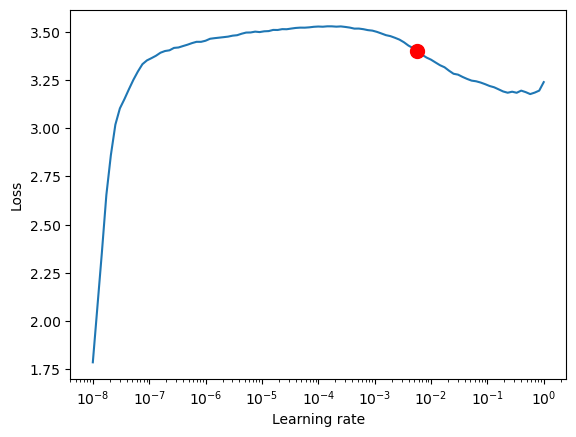

In [26]:
mlp_experiment_name = "MLP-v0"

trainer = L.Trainer(
    devices="auto", # (os.cpu_count() / 2)
    callbacks=[
        # EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
        ValPercentageEarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta_percentage=0.01),
        # ModelCheckpoint(
        #     monitor="val_loss",
        #     mode="min",
        #     save_top_k=1,
        #     every_n_epochs=5,
        #     enable_version_counter=False,
        #     dirpath=f"lightning_logs/checkpoints/{mlp_experiment_name}",
        #     filename=f"best_model_{mlp_experiment_name}",
        # ),
    ],
    logger=CSVLogger(save_dir="logs/", name=mlp_experiment_name),
    max_epochs=100,
    precision='bf16-mixed',
    default_root_dir="lightning_logs/",
)

# # Create a Tuner
tuner = Tuner(trainer)

# finds learning rate automatically and update hparams.lr to that learning rate
lr_finder = tuner.lr_find(lightningmodel, datamodule=dm)
fig = lr_finder.plot(suggest=True)
#fig.savefig("lr_suggest.pdf")
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)
# update hparams of the model
lightningmodel.learning_rate = new_lr

In [27]:
# training
trainer.fit(model=lightningmodel, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())
# trainer.validate()
# trainer.test()


  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 15.5 K | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
-----------------------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

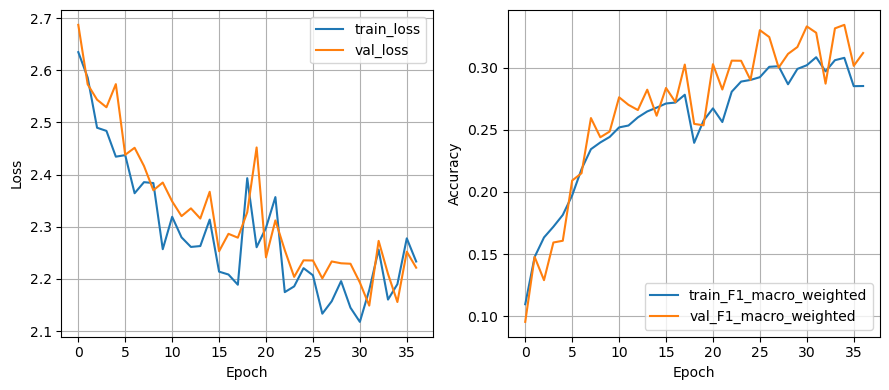

In [28]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

def plot_training_metrics(metrics: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Plot metrics from a dataframe.
    Args:
        metrics (pd.DataFrame): metrics dataframe from lightning trainer logger
        **kwargs: additional arguments to pass to the plot function

    Returns:
        pd.DataFrame: dataframe with the metrics
    """
    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    # Plot 1: Loss
    df_metrics[["train_loss", "val_loss"]].plot(
        ax=axes[0], grid=True, legend=True, xlabel="Epoch", ylabel="Loss", **kwargs
    )
    # Plot 2: Accuracy
    df_metrics[["train_F1_macro_weighted", "val_F1_macro_weighted"]].plot(
        ax=axes[1], grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy", **kwargs
    )

    plt.tight_layout()
    plt.show()

    return df_metrics

df_metrics = plot_training_metrics(metrics)

In [29]:
df_metrics.tail(10)

,epoch,step,train_F1_macro_weighted,train_loss,val_F1_macro_weighted,val_loss
27,27,22943.631579,0.301036,2.157101,0.299934,2.233467
28,28,23791.842105,0.286536,2.195743,0.310950,2.229976
29,29,24620.111111,0.298885,2.144799,0.316496,2.229084
30,30,25443.526316,0.301834,2.117626,0.333088,2.193127
31,31,26291.736842,0.308274,2.178716,0.327964,2.148804
32,32,27120.000000,0.296887,2.256157,0.287024,2.272950
33,33,27943.421053,0.305899,2.160369,0.331500,2.209532
34,34,28791.631579,0.307788,2.189935,0.334317,2.155709
35,35,29619.888889,0.285020,2.277789,0.301358,2.252200
36,36,30443.315789,0.285134,2.233391,0.311695,2.221536


In [30]:
score = trainer.test(model=lightningmodel, dataloaders=dm.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.3108748197555542     │
└───────────────────────────┴───────────────────────────┘

In [31]:
score[0]['test_F1_macro_weighted']

0.3108748197555542

In [32]:
# make predictions on test data and evaluate
preds_y_test = torch.cat(trainer.predict(model=lightningmodel, dataloaders=dm.test_dataloader()))
# inverse transform to get back to original labels
preds_y_test = dm.label_encoder_target.inverse_transform(preds_y_test.reshape(-1, 1))
y_test = dm.label_encoder_target.inverse_transform(dm.test_dataset.get_dataframe.iloc[:, -1].values.reshape(-1, 1))
# calculate classification report
print(classification_report(y_test, preds_y_test))

Predicting: |          | 0/? [00:00<?, ?it/s]

                            precision    recall  f1-score   support

   Blister and Insert Card       0.25      0.45      0.32      1749
  Blister and sealed blist       0.47      0.39      0.42      1582
            Book packaging       0.00      0.00      0.00        20
Cardb. Sleeve w - w/o Shr.       0.00      0.00      0.00       135
  Cardboard hanger w/o bag       0.00      0.00      0.00        80
    Carton cover (Lid box)       0.00      0.00      0.00       130
   Carton tube with or w/o       0.00      0.00      0.00        20
                      Case       0.00      0.00      0.00        97
         Corrugated carton       0.00      0.00      0.00       774
        Countertop display       0.00      0.00      0.00        30
                  Envelope       0.00      0.00      0.00        59
          Fabric packaging       0.00      0.00      0.00        20
            Folding carton       0.35      0.36      0.36      1644
              Hanger/ Clip       0.37      0.54